In [1]:
from __future__ import print_function
import numpy as np
import h5py
import glob
import math
import os
import shutil
from scipy import signal
from scipy.signal import butter, lfilter
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Conv1D, MaxPooling1D, UpSampling1D, Flatten, Dropout, Reshape 
from keras.layers import Bidirectional, BatchNormalization, ZeroPadding1D, Conv2DTranspose
from keras.models import Model
from keras import backend as K
from tensorflow.keras.optimizers import SGD, Adam
#from keras.optimizers import SGD, Adam
from keras import regularizers
#from keras.engine.topology import Layer, InputSpec
from tensorflow.keras.layers import Layer, InputSpec
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau, EarlyStopping
from keras.initializers import VarianceScaling
from keras.callbacks import CSVLogger
from scipy.optimize import linear_sum_assignment as linear_assignment
#from sklearn.utils.linear_assignment_ import linear_assignment
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
#import metrics
import matplotlib.pyplot as plt
from matplotlib.pyplot import savefig

import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('muted')

In [2]:
x = np.load('innorm-events-stft14min_2.5-13.6.npy') 
x.shape

(6993, 64, 128)

# Building the autoencoder

In [4]:
from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import MaxPooling2D, Flatten, Reshape, UpSampling2D
from keras.models import Model, Sequential
import keras.backend as K 

inp = Input(shape=(64, 128, 1))  
e = Conv2D(4, (3, 3), activation='tanh', padding='same')(inp)
e = MaxPooling2D((2, 2), padding='same')(e)
e = Conv2D(2, (3, 3), activation='tanh', padding='same')(e)
e = MaxPooling2D((2, 2), padding='same')(e)


shape_before_flattening = K.int_shape(e)
encoded = Flatten()(e)
d = Reshape(shape_before_flattening[1:])(encoded)

d = Conv2D(2, (3, 3), activation='tanh', padding='same')(d)
d = UpSampling2D((2, 2))(d)
d = Conv2D(4, (3, 3), activation='tanh', padding='same')(d)
d = UpSampling2D((2, 2))(d)
decoded = Conv2D(1, (3, 3), padding='same')(d)

autoencoder = Model(inputs=inp, outputs=decoded, name='autoencoder')
encoder = Model(inputs=inp, outputs=encoded, name='encoder')
#autoencoder.summary()

from keras.utils.vis_utils import plot_model
#from keras.utils import plot_model
#plot_model(autoencoder, to_file='autoencoder.png', show_shapes=True)
from IPython.display import Image, display
#Image(filename='autoencoder.png')
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 128, 1)]      0         
                                                                 
 conv2d_5 (Conv2D)           (None, 64, 128, 4)        40        
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 32, 64, 4)        0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 32, 64, 2)         74        
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 16, 32, 2)        0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 1024)              

# Pretraining of the autoencoder

In [5]:
autoencoder.compile(optimizer='adam', loss='mse')
csv_logger = CSVLogger('pretrain_log.csv')

autoencoder.fit(x, x, batch_size=128, epochs=50, callbacks=[csv_logger])

Epoch 1/50
55/55 [==============================] - 10s 174ms/step - loss: 0.2465
Epoch 2/50
55/55 [==============================] - 10s 174ms/step - loss: 0.2430
Epoch 3/50
55/55 [==============================] - 10s 176ms/step - loss: 0.2287
Epoch 4/50
55/55 [==============================] - 10s 182ms/step - loss: 0.1980
Epoch 5/50
55/55 [==============================] - 10s 184ms/step - loss: 0.1726
Epoch 6/50
55/55 [==============================] - 10s 185ms/step - loss: 0.1550
Epoch 7/50
55/55 [==============================] - 11s 192ms/step - loss: 0.1421
Epoch 8/50
55/55 [==============================] - 11s 197ms/step - loss: 0.1320
Epoch 9/50
55/55 [==============================] - 11s 193ms/step - loss: 0.1238
Epoch 10/50
55/55 [==============================] - 11s 191ms/step - loss: 0.1172
Epoch 11/50
55/55 [==============================] - 11s 192ms/step - loss: 0.1117
Epoch 12/50
55/55 [==============================] - 10s 185ms/step - loss: 0.1070
Epoch 13/50
5

In [6]:
decoder = Model(inputs=encoded, outputs=decoded, name='decoder')
encoded_imgs = encoder.predict(x)
decoded_imgs = decoder.predict(encoded_imgs)


In [7]:
y = np.load('events-stft14min_2.5-13.6.npy') 


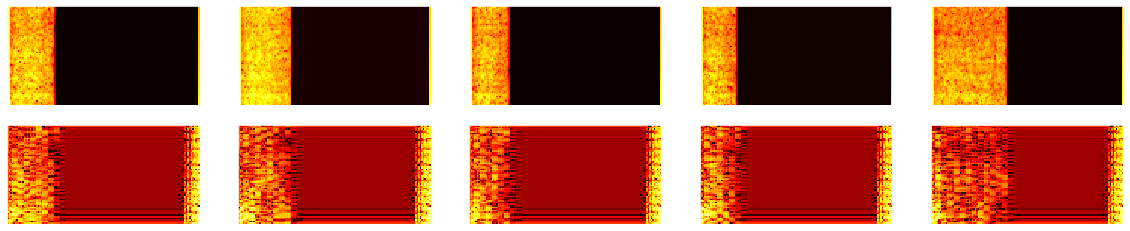

In [9]:
# Compare the input and output of the autoencoder

import librosa
import librosa.display


s=1
e=5
n = e-s

plt.figure(figsize=(20, 4))
for i in range(s,e):
    # Display original
    ax = plt.subplot(2, n, i-s + 1)
    dnor= x[i]*np.std (y)+ np.mean(y)
    dnordecode= decoded_imgs[i,:,:,0]*np.std (y)+ np.mean(y)
    librosa.display.specshow(librosa.power_to_db(dnor, ref=np.max), alpha=None, cmap='hot', shading='flat', antialiased=True)
    #plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i-s + 1 + n)
    librosa.display.specshow(librosa.power_to_db(dnordecode, ref=np.max), alpha=None, cmap='hot', shading='flat', antialiased=True)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# Guassian Mixture Models

In [10]:
# Gaussian Mixture Models

from sklearn import mixture
gmm = mixture.GaussianMixture (n_components=7, covariance_type='full').fit(encoder.predict(x))

labels = gmm.predict(encoder.predict(x))
np.savetxt('labels-GMM.txt',  labels, fmt='%i', delimiter=',')


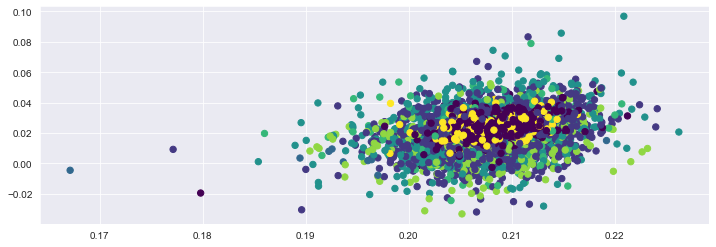

In [11]:
fig = plt.figure(figsize=(12, 4))
plt.scatter(encoder.predict(x)[:, 0], encoder.predict(x)[:, 1], c=labels, s=40, cmap='viridis')
